# Write to fasta format

In [9]:
import pandas as pd
import numpy as np
# Convert the seq into a fasta file

# data_file = 'examples/Savinase_test/data.csv'
# data_file = 'examples/Savinase_test/100k_samples.txt'
# data_file = 'examples/Savinase_casein/data.csv'
# data_file = 'examples/Savinase_stab/data.csv'
data_file = 'examples/Savinase_stab2/data.csv'
# data_file = 'examples/Savinase_express/data.csv'
# data_file = 'examples/Savinase_washing/data.csv'
# data_file = 'examples/Savi_gen_output/data.csv'
df_data = pd.read_csv(data_file)
# df_data.rename(columns={'aa_seqs':'seq'}, inplace=True)
# df_data.to_csv(data_file, index=False)
df_data.head()

,seq,Mutant,ID,Stability,Source,log_fitness
0,GQTVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,A1G/S3T/N43R/N76D/N185E/S188E/Q191N/A194P/Q206...,M166,0.154098,bsj,-1.870164
1,GQTVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,A1G/S3T/N43R/N76D/S87N/G118M/P129Q/S130A/N185E...,M182,1.816393,bsj,0.596853
2,GQTVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,A1G/S3T/N43R/N76D/S87N/G118M/P129Q/S130A/V205I...,M241,1.337705,bsj,0.290955
3,GQTVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,A1G/S3T/N43R/N76D/S87N/G118M/P129Q/S130A/V205I...,M135,1.639344,bsj,0.494296
4,GQTVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,A1G/S3T/N43R/N76D/S87N/G118M/P129Q/S130A/V205I...,M136,0.750820,bsj,-0.286590


In [10]:
# Write seq to fasta file
with open(data_file + '.fasta', 'w') as f:
    for i, seq in enumerate(df_data['seq']):
        f.write(f'>seq_{i}\n{seq}\n')

# Embedding 

1. Remove the sequences containing termination codon `*`.
2. Get the esm2 embeddings with the following commands.
```shell
esm-extract esm2_t33_650M_UR50D ev_onehot/examples/Savinase_test/seq.fasta data/savinase_test_esm2_650M --repr_layers 0 32 33 --include per_tok mean
```

In [4]:
import os 
import torch

train = False
# train = True

if train:

    data_path = "examples/Savinase_test/esm1v_650M_1" 
    esm_embd = []

    for id in range(len(df_data['seq'])):
        emb = torch.load(os.path.join(data_path, f'seq_{id}.pt'))['mean_representations'][33]
        esm_embd.append(emb)
    esm_embd = torch.stack(esm_embd, dim=0).numpy()
    np.save(os.path.join('examples/Savinase_test', 'esm_embd.npy'), esm_embd)
else:
    esm_embd = np.load(os.path.join('examples/Savinase_test/esm1v_650M_1', 'esm1v_650M_1.npy'))
print(esm_embd.shape)


(2605, 1280)


# Build a simple head model

In [6]:
import numpy as np
import os

esm_embd = np.load(os.path.join('examples/Savinase_test/esm1v_650M_1', 'esm1v_650M_1.npy'))

Xs = esm_embd
Ys = df_data['log_fitness'].values

## Split data

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

In [8]:
train_size = 0.8
seed = 27
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, Ys, train_size=train_size, random_state=seed)

Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((2084, 1280), (521, 1280), 2084, 521)

## Visualize data embeddings

In [9]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

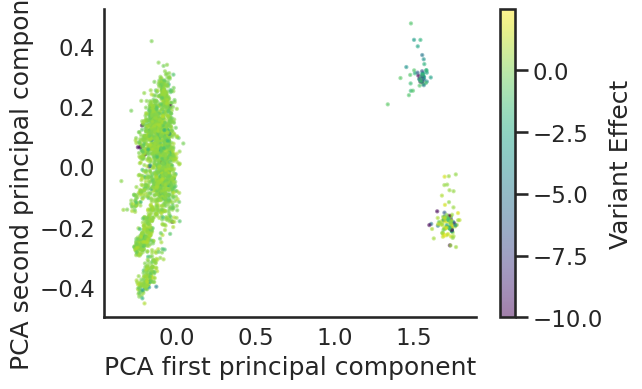

In [10]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.', cmap='viridis', s=10, alpha=0.5)
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [11]:
reg_model = RandomForestRegressor()
reg_model.fit(Xs_train_pca, ys_train)

RandomForestRegressor()

In [12]:
from scipy.stats import spearmanr

Xs_test_pca = pca.transform(Xs_test)
ys_pred = reg_model.predict(Xs_test_pca)
spearman_r =spearmanr(ys_test, ys_pred)
print(f'{spearman_r}')

SignificanceResult(statistic=0.5122552635255159, pvalue=3.396569171179326e-36)


In [13]:
ys_train_pred = reg_model.predict(Xs_train_pca)

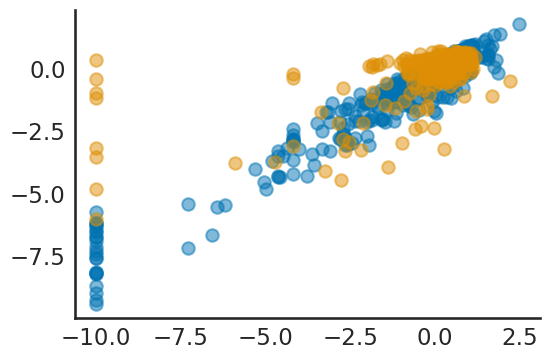

In [14]:
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.scatter(ys_train, ys_train_pred, label='train', color=plot_style_utils.CAT_PALETTE[0], alpha=0.5)
ax.scatter(ys_test, ys_pred, label='test', color=plot_style_utils.CAT_PALETTE[1], alpha=0.5)